First we need to prepare our work environment and install the necessary Python packages

In [1]:
%pip install -q cython==0.29.15 # It's needed for installing pycocotools
%pip install -q numpy==1.18.1 opencv-python-headless==4.2.0.32 \
    torch==1.4.0 torchvision==0.5.0 \
    albumentations==0.4.5 tqdm==4.43.0 \
    pycocotools==2.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.6/21.6 MB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.4/753.4 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.1/116.1 KB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 73.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.4/631.4 KB 55.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.8/214.8 KB 26.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all 

# Imports

In [2]:
import os
import random
from pathlib import Path
from urllib.request import urlretrieve, urlcleanup
from zipfile import ZipFile

import albumentations as albm
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pycocotools.coco import COCO
import torch
import torch.nn as nn
import torchvision
from tqdm.notebook import tqdm

%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 1337
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Flip values for slower training speed, but more determenistic results.
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

# Global variables for training

This training notebook uses COCO dataset: http://cocodataset.org/
The annotations in this dataset belong to the COCO Consortium and are licensed under a Creative Commons Attribution 4.0 License. http://cocodataset.org/#termsofuse
Images are part of flickr and have corresponding licenses. To check license for each image please refer to the contents of http://images.cocodataset.org/annotations/image_info_unlabeled2017.zip

### Available COCO classes

You can check available data here http://cocodataset.org/#explore

COCO has 80 categories:

person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic light, fire hydrant, stop sign, parking meter, bench, bird, cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, sports ball, kite, baseball bat, baseball glove, skateboard, surfboard, tennis racket, bottle, wine glass, cup, fork, knife, spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, hot dog, pizza, donut, cake, chair, couch, potted plant, bed, dining table, toilet, tv, laptop, mouse, remote, keyboard, cell phone, microwave, oven, toaster, sink, refrigerator, book, clock, vase, scissors, teddy bear, hair drier, toothbrush

In [3]:
COCO_CATEGORY = 'hair drier'  # target category for segmentation

In [4]:
COCO_ANNOTATIONS_PATH = './annotations/instances_train2017.json'
COCO_IMAGES_PATH = './train2017/'

NUM_TRAINING_STEPS = 4000  # number of steps for training, longer is better
VALIDATION_FREQUENCY = 200  # log validation every N steps
BATCH_SIZE = 64  # number of images per batch
NUM_WORKERS = 2  # number of CPU threads available for image preprocessing

# This controls input and output resolution for the network.
# Lower values lead to worse mask quality, but faster network inference.
# Change carefully.
INPUT_HEIGHT = 256   
INPUT_WIDTH = 128

# This variable below will let this code run on GPU if CUDA device is available.
DEVICE = torch.device('cpu')
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    torch.cuda.manual_seed(123)

Colab's GPU runtimes don't have enough free drive space to store entire COCO dataset, so we'll have to unpack only the files that we need for training particular category. If you encounter message "Disk is almost full" on Google Colab, please click the "ignore" button.

In [5]:
def download_file(link, filename):
    if Path(filename).exists():
        return
    progress_bar = tqdm(desc=filename,
                        dynamic_ncols=True, leave=False,
                        mininterval=5, maxinterval=30,
                        unit='KiB', unit_scale=True,
                        unit_divisor=1024)
    def update_progress(count, block_size, total_size):
        if progress_bar.total is None:
            progress_bar.reset(total_size)
        progress_bar.update(count * block_size - progress_bar.n)
    urlretrieve(link, filename, reporthook=update_progress)
    urlcleanup()
    progress_bar.close()


if not os.path.isfile('./train2017.zip'):
    download_file('http://images.cocodataset.org/zips/train2017.zip', 'train2017.zip')

if not os.path.isfile('./annotations_trainval2017.zip'):
    download_file('http://images.cocodataset.org/annotations/annotations_trainval2017.zip',
                  'annotations_trainval2017.zip')
    with ZipFile('./annotations_trainval2017.zip', 'r') as archive:
        archive.extractall()

Lets load the images and find all image ids that contain our desired class.

In [6]:
coco = COCO(COCO_ANNOTATIONS_PATH)
cat_ids = coco.getCatIds(catNms=[COCO_CATEGORY])
img_ids = coco.getImgIds(catIds=cat_ids)

loading annotations into memory...
Done (t=16.75s)
creating index...
index created!


We also need some images that don't contain our desired class.
Otherwise the network would always expect to have our object in the input image and will have lots of false positives, like segmenting faces as pizzas.

In [7]:
with ZipFile('./train2017.zip') as archive:
    coco_images_list = archive.namelist()
all_ids = [int(i.split('train2017/')[-1][:-4]) for i in coco_images_list[1:]]
non_class_img_ids = list(set(all_ids) - set(img_ids))

negative_samples = np.random.choice(non_class_img_ids,
                                    size=len(img_ids) // 2, 
                                    replace=False)
positive_samples = np.random.choice(img_ids, 
                                    size=len(img_ids) - (len(img_ids) // 10), 
                                    replace=False)
train_img_ids = np.concatenate((positive_samples, negative_samples))
np.random.shuffle(train_img_ids)
val_img_ids = np.array(list(set(img_ids) - set(train_img_ids)))

Now we will extract only the images that we need for training, since COCO is pretty large and contains lots of other categories.

In [8]:
if not os.path.isdir('./train2017'):
    os.mkdir('./train2017')

train_images = [str(i).zfill(12) + '.jpg' for i in train_img_ids]
val_images = [str(i).zfill(12) + '.jpg' for i in val_img_ids]

with ZipFile('./train2017.zip', 'r') as archive:
    for image in tqdm(val_images, dynamic_ncols=True, leave=False):
        archive.extract('train2017/' + image, './')
with ZipFile('./train2017.zip', 'r') as archive:
    for image in tqdm(train_images, dynamic_ncols=True, leave=False):
        archive.extract('train2017/' + image, './')

Let's also load an image that we'll use to check the quality of the segmentation while we train the network.

In [9]:
TEST_IMG = cv2.imread('./hair_drier_image.jpg')[:, :, ::-1]

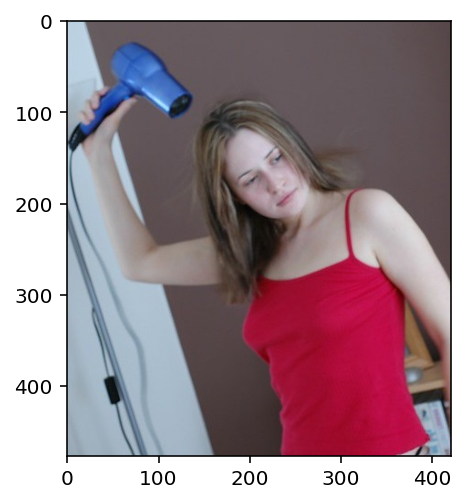

In [10]:
plt.imshow(TEST_IMG);

# Model definition

This model is based on Mobilenet V2 https://arxiv.org/abs/1801.04381.
This is a good starting place for general segmentation model, however there were a range of new architectures optimized for mobile inference, including Mobilenet V3 https://arxiv.org/abs/1905.02244.

This model runs on average 12.3ms on iPhone 6S.

Our model will use pretrained weights of Mobilenet V2, however these weights assume the input to be RGB in range [0, 1] and input should be normalized. We will disregard this and just use pretrained weights as good initialization for our network. You can play around and check if using the network from scratch without pretrained weights helps you achieve better segmentation quality.

### Important point regarding input and output ranges
Lens studio feeds the network camera input as RGB images with values in range [0, 255]. This is uncommon in general for neural networks, but in our case we will train the network with this range from scratch, to avoid doing rescaling on network export or import. That's why we need to scale the weights of the first layer – they were trained with normalized values in different range.

In [11]:
# We also need to replace Mobilenet's ReLU6 activations with ReLU. 
# There is no noticeable difference in quality, but this will
# allow us to use CoreML for mobile inference on iOS devices.
def replace_relu6_with_relu(model):
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            model._modules[name] = replace_relu6_with_relu(model=module)
        if isinstance(module, nn.ReLU6):
            model._modules[name] = nn.ReLU()
    return model


class SegmentationNet(nn.Module):
    def __init__(self):
        super().__init__()
        mobilenet = torchvision.models.mobilenet_v2(width_mult=0.5)

        # We reuse state dict from mobilenet v2 width width_mult == 1.0.
        # This is not the optimal way to use pretrained models, but in this case
        # it gives us good initialization for faster convergence.
        state_dict = torchvision.models.mobilenet_v2(pretrained=True).state_dict()
        target_dict = mobilenet.state_dict()
        for k in target_dict.keys():
            if len(target_dict[k].size()) == 0:
                continue
            state_dict[k] = state_dict[k][:target_dict[k].size(0)]
            if len(state_dict[k].size()) > 1:
                state_dict[k] = state_dict[k][:, :target_dict[k].size(1)]

        mobilenet.load_state_dict(state_dict)

        weight = mobilenet.features[0][0].weight.detach()
        mobilenet.features[0][0].weight = nn.Parameter(data=weight / 255.)

        mobilenet = replace_relu6_with_relu(mobilenet)

        self.features = mobilenet.features[:-2]
        self.upscale0 = nn.Sequential(
            nn.Conv2d(80, 48, 1, 1, 0, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU()
        )
        self.upscale1 = nn.Sequential(
            nn.Conv2d(48, 16, 3, 1, 1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.upscale2 = nn.Sequential(
            nn.Conv2d(16, 16, 3, 1, 1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.upscale3 = nn.Sequential(
            nn.Conv2d(16, 8, 3, 1, 1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        self.upscale4 = nn.Sequential(
            nn.Conv2d(8, 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(4),
            nn.ReLU()
        )
        self.upscale5 = nn.Conv2d(4, 1, 3, 1, 1, bias=True)

    def forward(self, x):
        out = x
        skip_outs = []
        for i in range(len(self.features)):
            out = self.features[i](out)
            if i in {1, 3, 6, 13}:
                skip_outs.append(out)
        out = self.upscale0(out)
        out = nn.functional.interpolate(out, scale_factor=2, mode='nearest')
        out = self.upscale1(out + skip_outs[3])
        out = nn.functional.interpolate(out, scale_factor=2, mode='nearest')
        out = self.upscale2(out + skip_outs[2])
        out = nn.functional.interpolate(out, scale_factor=2, mode='nearest')
        out = self.upscale3(out + skip_outs[1])
        out = nn.functional.interpolate(out, scale_factor=2, mode='nearest')
        out = self.upscale4(out + skip_outs[0])
        out = nn.functional.interpolate(out, scale_factor=2, mode='nearest')
        out = self.upscale5(out)
        return torch.sigmoid(out)

# Dataset

The class below specifies image loading and augmentations to add variety to our dataset and increase network stability to different input conditions.

In [12]:
class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, coco, image_list,
                 category, augmentations):
        self.image_folder = image_folder
        self.coco = coco
        self.image_list = image_list
        self.category = category
        self.augmentations = augmentations

    def __getitem__(self, item):
        image_name = self.image_list[item]
        image_path = os.path.join(self.image_folder,
                                  str(image_name).zfill(12) + '.jpg')
        image = cv2.imread(image_path)[:, :, ::-1]
        ann_ids = coco.getAnnIds(imgIds=image_name, catIds=self.category,
                                 iscrowd=None)
        annotations = coco.loadAnns(ann_ids)
        target = []
        if len(annotations) == 0:
            target = np.zeros((image.shape[0], image.shape[1]))
        else:
            for ann in annotations:
                target.append(coco.annToMask(ann))
        target = np.array(target).sum(axis=0)
        target = np.clip(target, 0, 1).astype('float')
        scaled_width = int(INPUT_HEIGHT * image.shape[1] / image.shape[0])
        image = cv2.resize(image, (scaled_width, INPUT_HEIGHT),
                           interpolation=cv2.INTER_LINEAR)
        target = cv2.resize(target, (scaled_width, INPUT_HEIGHT),
                            interpolation=cv2.INTER_NEAREST)
        augmented = self.augmentations(image=image, mask=target)
        image = augmented['image']
        target = augmented['mask']

        image = image.astype('float32')

        return {'image': image.transpose(2, 0, 1),
                'target': target[np.newaxis, :, :].astype('float32')}

    def __len__(self):
        return len(self.image_list)

In [13]:
train_augmentations = albm.Compose([
    albm.ShiftScaleRotate(rotate_limit=10),
    albm.PadIfNeeded(min_height=INPUT_HEIGHT, min_width=INPUT_WIDTH,
                     always_apply=True),
    albm.RandomCrop(height=INPUT_HEIGHT, width=INPUT_WIDTH,
                    always_apply=True),
    albm.HueSaturationValue(),
    albm.RandomBrightnessContrast(),
    albm.GaussNoise(),
    albm.MotionBlur(),
    albm.HorizontalFlip()
])
val_augmentations = albm.Compose([
    albm.PadIfNeeded(min_height=INPUT_HEIGHT, min_width=INPUT_WIDTH,
                     always_apply=True),
    albm.Crop(0, 0, INPUT_WIDTH, INPUT_HEIGHT, always_apply=True)
])

train_dataset = CocoDataset(COCO_IMAGES_PATH, coco, train_img_ids,
                            cat_ids, train_augmentations)
val_dataset = CocoDataset(COCO_IMAGES_PATH, coco, val_img_ids, 
                          cat_ids, val_augmentations)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                           num_workers=NUM_WORKERS, drop_last=True,
                                           shuffle=True,
                                           worker_init_fn=lambda _: np.random.seed())
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,
                                         num_workers=NUM_WORKERS, drop_last=False,
                                         shuffle=False,
                                         worker_init_fn=lambda _: np.random.seed())

# Optimizer setup

Here we set up training and model itself. We'll also set up learning rate scheduler to drop learning rate if our network training platoes.

In [14]:
model = SegmentationNet()
model = model.to(device=DEVICE)
loss = nn.BCELoss()
loss = loss.to(device=DEVICE)
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',
                                                       factor=.1, patience=3,
                                                       verbose=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth


For metrics we will only check IoU, accuracy and loss value.

In [15]:
class Metrics():
    def __init__(self, loss_function):
        self.loss_function = loss_function
        self.loss_value = 0
        self.iou = 0
        self.accuracy = 0
        self.batches = 0

    def add_batch(self, prediction, target):
        loss_value = self.loss_function(prediction, target)
        thresholded_prediction = (prediction >= .5).to(torch.float32)
        accuracy = (thresholded_prediction ==
                    target).to(torch.float32).mean().item()
        intersection = ((thresholded_prediction == 1) & (target == 1)).sum((2, 3))
        union = ((thresholded_prediction == 1) | (target == 1)).sum((2, 3))
        iou = (intersection.to(torch.float32) /
               (union.to(torch.float32) + 1e-7)).mean().item()
        self.loss_value = (self.loss_value * self.batches + loss_value) / \
                          (self.batches + 1)
        self.iou = (self.iou * self.batches + iou) / (self.batches + 1)
        self.accuracy = (self.accuracy * self.batches + accuracy) / \
                        (self.batches + 1)
        self.batches += 1

    def reset_metrics(self):
        self.loss_value = 0
        self.iou = 0
        self.accuracy = 0
        self.batches = 0

This helper function will display image and network output side by side to see the progress during training

In [16]:
def show_test_image_quality(model, image):
    model_input = torch.zeros(1, 3, INPUT_HEIGHT, INPUT_WIDTH,
                              dtype=torch.float32, device=DEVICE)
    new_height = int(image.shape[0] * INPUT_WIDTH / image.shape[1])
    resized_image = cv2.resize(image,
                               (INPUT_WIDTH, new_height),
                               interpolation=cv2.INTER_CUBIC)
    resized_image = resized_image.astype('float32')
    model_input[:, :, :new_height, :] = torch.tensor(resized_image.transpose(2, 0, 1))
    model_output = model(model_input)
    output_mask = model_output[0].detach().cpu().numpy().transpose(1, 2, 0)[:new_height]

    output_image = resized_image / 255.
    plot_image = np.zeros((output_image.shape[0], output_image.shape[1] * 3, 3))
    plot_image[:, :INPUT_WIDTH] = output_image
    plot_image[:, INPUT_WIDTH:INPUT_WIDTH * 2] = output_mask
    plot_image[:, INPUT_WIDTH * 2:] = output_image * output_mask

    plt.imshow(plot_image)
    plt.axis('off')
    plt.show()

# Train loop

[200] train 	 loss: 0.06307
[200] val 	 loss: 0.07974	 IoU: 0.00000	 accuracy: 0.98092


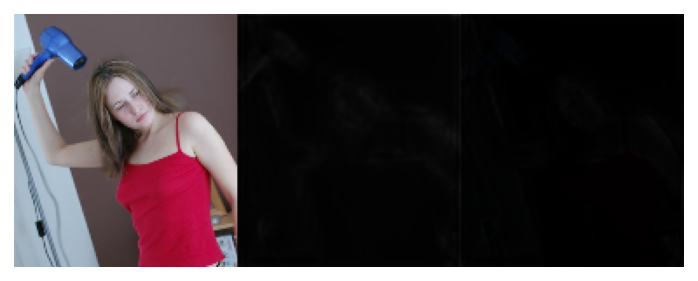

[400] train 	 loss: 0.05281
[400] val 	 loss: 0.07944	 IoU: 0.00000	 accuracy: 0.98092


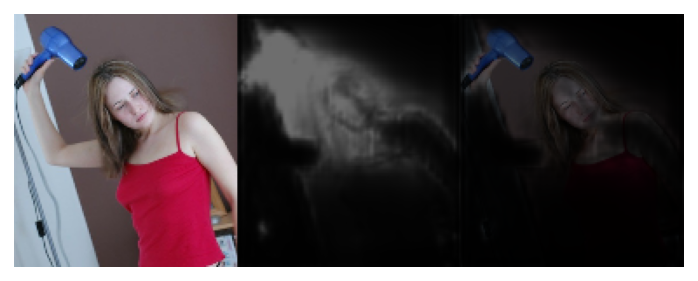

[600] train 	 loss: 0.05700
[600] val 	 loss: 0.09865	 IoU: 0.00000	 accuracy: 0.98092


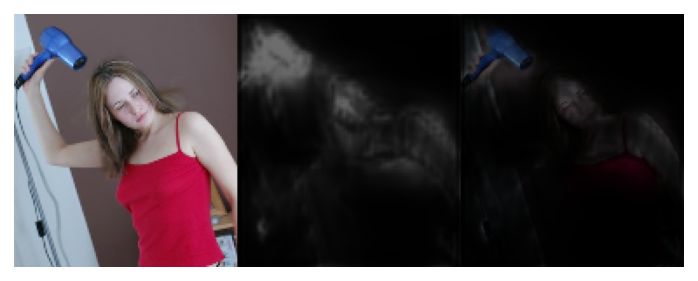

[800] train 	 loss: 0.03528
[800] val 	 loss: 0.09201	 IoU: 0.00000	 accuracy: 0.98092


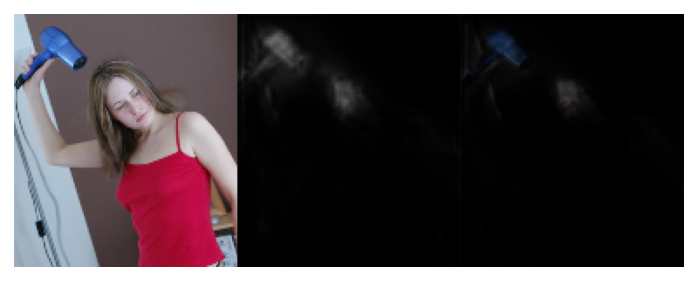

[1000] train 	 loss: 0.04031
[1000] val 	 loss: 0.08122	 IoU: 0.00000	 accuracy: 0.98092


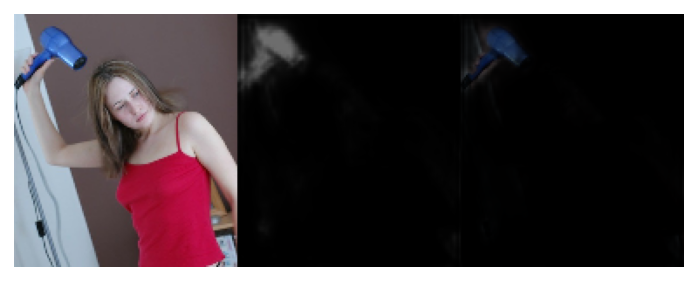

[1200] train 	 loss: 0.03809
[1200] val 	 loss: 0.09936	 IoU: 0.00000	 accuracy: 0.98092
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.


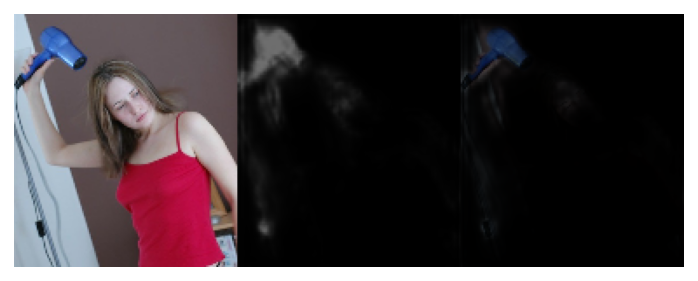

[1400] train 	 loss: 0.03274
[1400] val 	 loss: 0.09613	 IoU: 0.00000	 accuracy: 0.98092


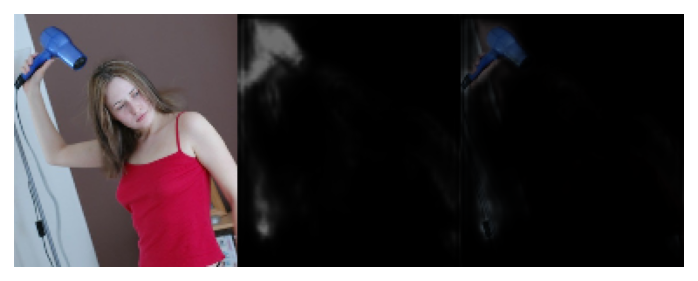

[1600] train 	 loss: 0.02515
[1600] val 	 loss: 0.10216	 IoU: 0.00000	 accuracy: 0.98092


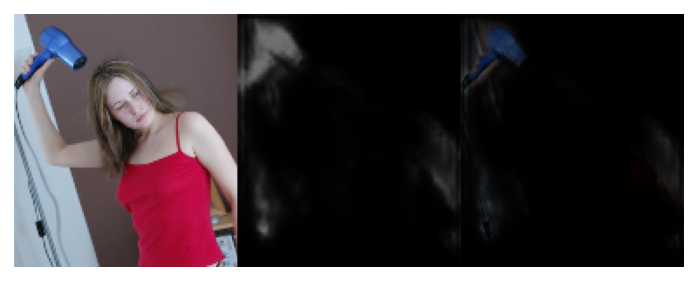

[1800] train 	 loss: 0.02680
[1800] val 	 loss: 0.09749	 IoU: 0.00000	 accuracy: 0.98092


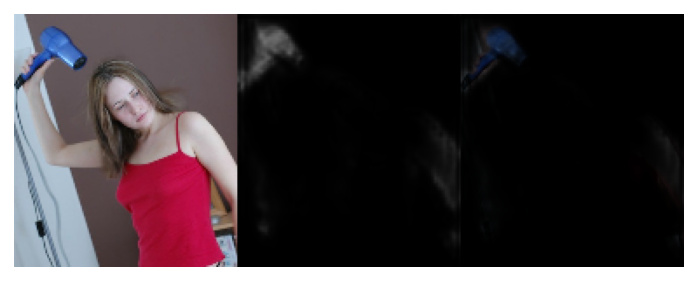

[2000] train 	 loss: 0.02657
[2000] val 	 loss: 0.10703	 IoU: 0.00000	 accuracy: 0.98092
Epoch    10: reducing learning rate of group 0 to 1.0000e-05.


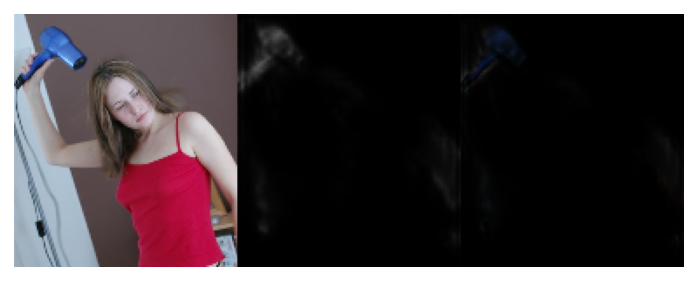

[2200] train 	 loss: 0.02718
[2200] val 	 loss: 0.09942	 IoU: 0.00000	 accuracy: 0.98092


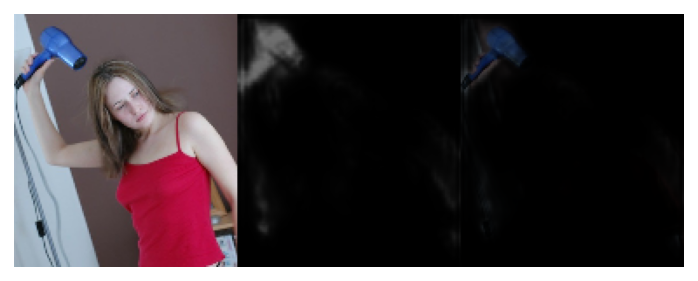

[2400] train 	 loss: 0.02684
[2400] val 	 loss: 0.10211	 IoU: 0.00000	 accuracy: 0.98092


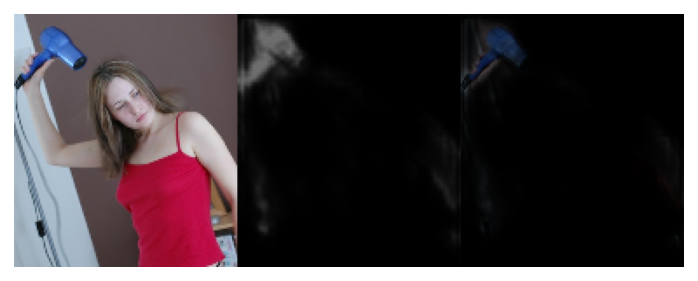

[2600] train 	 loss: 0.02963
[2600] val 	 loss: 0.10385	 IoU: 0.00000	 accuracy: 0.98092


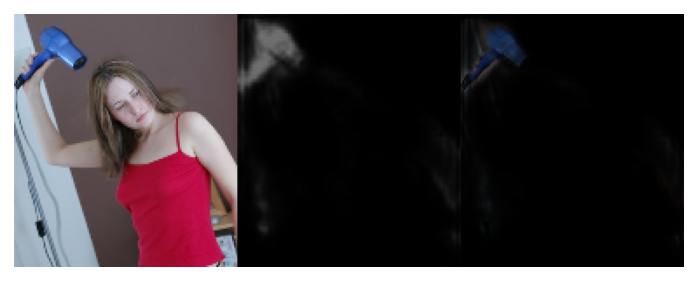

[2800] train 	 loss: 0.02942
[2800] val 	 loss: 0.10511	 IoU: 0.00000	 accuracy: 0.98092
Epoch    14: reducing learning rate of group 0 to 1.0000e-06.


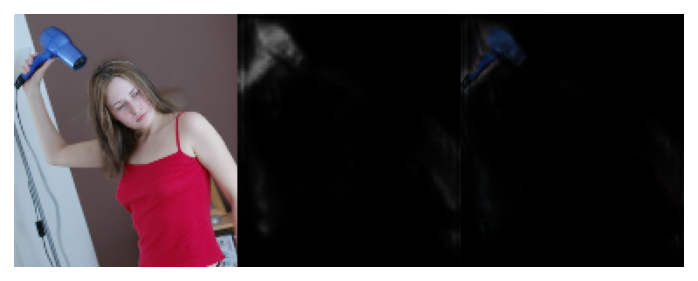

[3000] train 	 loss: 0.02790
[3000] val 	 loss: 0.10453	 IoU: 0.00000	 accuracy: 0.98092


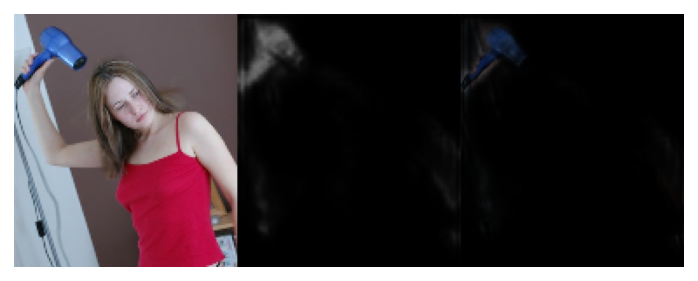

[3200] train 	 loss: 0.02420
[3200] val 	 loss: 0.10402	 IoU: 0.00000	 accuracy: 0.98092


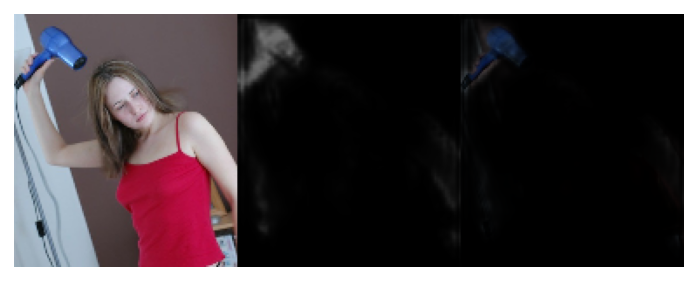

[3400] train 	 loss: 0.02535
[3400] val 	 loss: 0.10383	 IoU: 0.00000	 accuracy: 0.98092


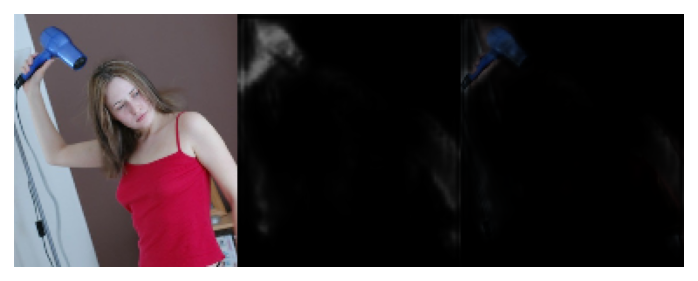

[3600] train 	 loss: 0.02381
[3600] val 	 loss: 0.10428	 IoU: 0.00000	 accuracy: 0.98092
Epoch    18: reducing learning rate of group 0 to 1.0000e-07.


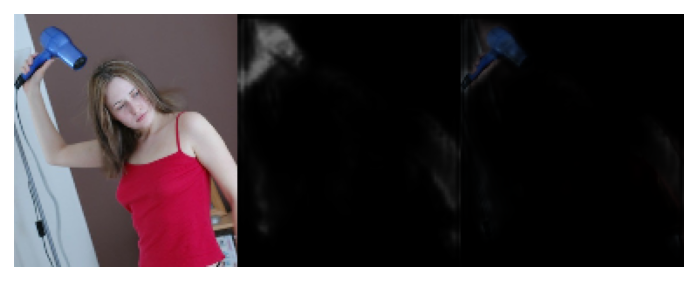

[3800] train 	 loss: 0.02414
[3800] val 	 loss: 0.10430	 IoU: 0.00000	 accuracy: 0.98092


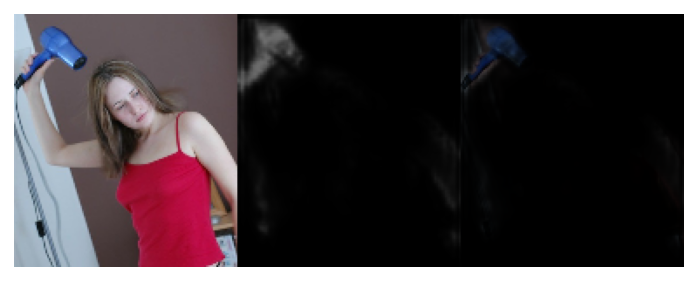

[4000] train 	 loss: 0.02927
[4000] val 	 loss: 0.10422	 IoU: 0.00000	 accuracy: 0.98092


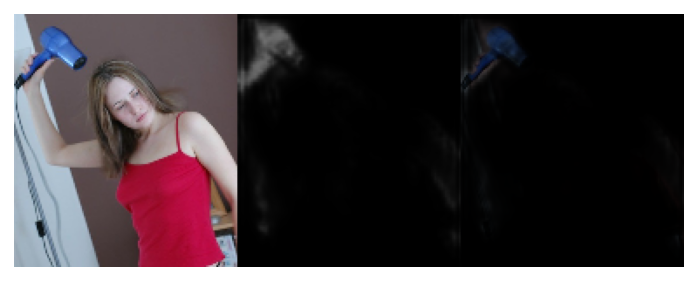

In [17]:
metrics = Metrics(loss)

progress = tqdm(desc='Training progress', total=NUM_TRAINING_STEPS,
                dynamic_ncols=True, leave=False)

batch_num = 0
while batch_num < NUM_TRAINING_STEPS:
    train_loss = 0
    model.train()
    bn = 0
    for batch in train_loader:
        batch_num += 1
        optimizer.zero_grad()

        batch['image'] = batch['image'].to(DEVICE)
        batch['target'] = batch['target'].to(DEVICE)

        loss_value = loss(model(batch['image']), batch['target'])
        loss_value.backward()
        optimizer.step()

        train_loss = (train_loss * bn + loss_value.item()) / (bn + 1)
        bn += 1
        
        # Next two lines make sure we don't update the progress bar too frequently
        if batch_num % int(NUM_TRAINING_STEPS / 1000) == 0:
            progress.update(int(NUM_TRAINING_STEPS / 1000))

        if batch_num % VALIDATION_FREQUENCY == 0:
            print("[{}] train \t loss: {:.5f}".format(batch_num, train_loss))
            train_loss = 0
            bn = 0

            model.eval()
            for batch_val in val_loader:
                batch_val['image'] = batch_val['image'].to(DEVICE)
                batch_val['target'] = batch_val['target'].to(DEVICE)

                prediction = model(batch_val['image']).detach()

                metrics.add_batch(prediction, batch_val['target'])

            print("[{}] val \t loss: {:.5f}\t IoU: {:.5f}\t accuracy: {:.5f}".format(
                batch_num, metrics.loss_value, metrics.iou, metrics.accuracy))
            scheduler.step(metrics.loss_value)

            show_test_image_quality(model, TEST_IMG)
            metrics.reset_metrics()

            model.train()

        if batch_num >= NUM_TRAINING_STEPS:
            break
progress.close()

# Export

### Imporant note regarding Lens Studio input and output ranges 

LensStudio sends RGB image to the network input with values in range [0, 255]. Our network is already trained for that, but if you trained the network with other input range you might need to adjust it when you import your ONNX file.

Current network output is in range [0, 1], but again LensStudio needs the output texture to have values in range [0, 255]. That's why we'll use wrapper class for our model that just runs the model and mutiplies output values by 255 to get them to the necessary range.

In [18]:
class ModelForExport(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def forward(self, x):
        return self.model(x) * 255

In [19]:
model.eval()
model_for_export = ModelForExport(model)
dummy_input = torch.randn(1, 3, INPUT_HEIGHT, INPUT_WIDTH, 
                          dtype=torch.float32, device=DEVICE)

output = model_for_export(dummy_input.detach())

input_names = ["data"]
output_names = ["prob"]

torch.onnx.export(model_for_export, dummy_input, 
                  "./hair_drier_segmentation.onnx", verbose=False, 
                  input_names=input_names, output_names=output_names)

/usr/local/lib/python3.8/dist-packages/torch/onnx/symbolic_helper.py:245: UserWarning: You are trying to export the model with onnx:Upsample for ONNX opset version 9. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11. Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior (like coordinate_transformation_mode and nearest_mode).
We recommend using opset 11 and above for models using this operator. 
  warnings.warn("You are trying to export the model with " + onnx_op + " for ONNX opset version "
